In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path =  "/content/drive/My Drive/"

Mounted at /content/drive


In [ ]:
!pip install underthesea

In [ ]:
!pip install phonlp

## Import Packages

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import pickle
import numpy as np
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import underthesea
import re
import phonlp
import torch

In [ ]:
# Function to load models based on model_type
def load_models(model_type):

    if model_type == 'bilstm_phobertbase':
      # Load features and tokenizer
        with open(path + 'features_162k_phobertbase.pkl', 'rb') as f:
              data_dict = pickle.load(f)
        tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
        phobert = phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
        max_len = 256
        # Load hyperparameters
        with open(path + 'hyperparameters/BiLSTM_phobertbase.json', 'r') as json_file:
              hyperparameters = json.load(json_file)

    else:
        raise ValueError("Invalid model type specified.")

    return tokenizer, data_dict, hyperparameters, max_len, phobert

## Load data

In [ ]:
# Load model-specific data and configurations
tokenizer, data_dict, hyperparameters, max_len, phobert = load_models("bilstm_phobertbase")

In [ ]:
# Load training, validation, and testing data
X_train = np.array(data_dict['X_train'])
X_val = np.array(data_dict['X_val'])
X_test = np.array(data_dict['X_test'])
y_train = data_dict['y_train'].values.astype(int)
y_val = data_dict['y_val'].values.astype(int)
y_test = data_dict['y_test'].values.astype(int)

In [ ]:
print(X_train.shape, X_test.shape, X_val.shape)

(113932, 1, 768) (24291, 1, 768) (24126, 1, 768)


## Build Model

In [ ]:
# Function to build the BiLSTM model
def build_bilstm_model(X_train, y_train, lstm_units_1, lstm_units_2, dense_units, dropout_rate, learning_rate):
    model = Sequential()
    # Input layer with the shape based on X_train
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    # First BiLSTM layer with dropout
    model.add(Bidirectional(LSTM(lstm_units_1, return_sequences=True)))
    model.add(Dropout(dropout_rate))

    # Second BiLSTM layer with dropout
    model.add(Bidirectional(LSTM(lstm_units_2, return_sequences=False)))
    model.add(Dropout(dropout_rate))

    # Dense layer with ReLU activation and dropout
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))

    # Final Dense layer with softmax activation
    model.add(Dense(y_train.shape[1], activation='softmax'))

    # Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model with categorical crossentropy loss and accuracy metric
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Use the hyperparameters to build the model
lstm_units_1 = hyperparameters['lstm_units_1']
lstm_units_2 = hyperparameters['lstm_units_2']
dense_units = hyperparameters['dense_units']
dropout_rate = hyperparameters['dropout_rate']
learning_rate = hyperparameters['learning_rate']
epochs = hyperparameters['epochs']
batch_size = hyperparameters['batch_size']

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 448)            1779456   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 448)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 288)               683136    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 288)               0         
                                                                 
 dense (Dense)               (None, 160)               46240     
                                                                 
 dropout_2 (Dropout)         (None, 160)               0

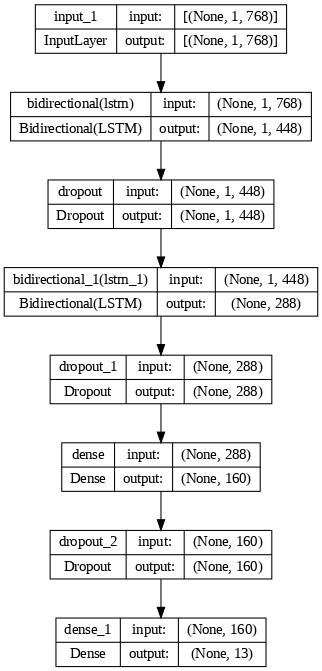

In [ ]:
# Build the BiLSTM model
model = build_bilstm_model(X_train, y_train, lstm_units_1, lstm_units_2, dense_units, dropout_rate, learning_rate)
model.summary()

# Print model summary and save model architecture diagram
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, to_file=path + 'bilstm_phobertbase_summary.png')

In [ ]:
# Start training time measurement
start_time = time.time()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

# End training time measurement
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f'Training time: {training_time:.2f} seconds')

# Save training time to JSON file
training_time_data = {
    'training_time_seconds': training_time
}

Epoch 1/30
594/594 [==============================] - 17s 13ms/step - loss: 0.6482 - accuracy: 0.7974 - val_loss: 0.4288 - val_accuracy: 0.8540
Epoch 2/30
594/594 [==============================] - 6s 10ms/step - loss: 0.4604 - accuracy: 0.8516 - val_loss: 0.4039 - val_accuracy: 0.8618
Epoch 3/30
594/594 [==============================] - 6s 10ms/step - loss: 0.4353 - accuracy: 0.8582 - val_loss: 0.3959 - val_accuracy: 0.8655
Epoch 4/30
594/594 [==============================] - 5s 9ms/step - loss: 0.4166 - accuracy: 0.8632 - val_loss: 0.3809 - val_accuracy: 0.8694
Epoch 5/30
594/594 [==============================] - 7s 11ms/step - loss: 0.4020 - accuracy: 0.8670 - val_loss: 0.3759 - val_accuracy: 0.8702
Epoch 6/30
594/594 [==============================] - 5s 9ms/step - loss: 0.3850 - accuracy: 0.8706 - val_loss: 0.3698 - val_accuracy: 0.8723
Epoch 7/30
594/594 [==============================] - 6s 10ms/step - loss: 0.3773 - accuracy: 0.8741 - val_loss: 0.3666 - val_accuracy: 0.8742


In [ ]:
model.save(path + 'bilstm_phobertbase.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluate

In [ ]:
# Define class names
class_names = ['Cong nghe', 'Doi song', 'Giai tri', 'Giao duc', 'Khoa hoc', 'Kinh te',
               'Nha dat', 'Phap luat', 'The gioi', 'The thao', 'Van hoa', 'Xa hoi', 'Xe co']

# Define evaluation function
def evaluate_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred_classes)
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    class_report = classification_report(y_true, y_pred_classes, target_names=class_names)

    # Convert classification report to DataFrame
    report_dict = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    return conf_matrix, report_df

In [ ]:
# Evaluate the model on test data
conf_matrix, report_df = evaluate_model(model, X_test, y_test, class_names)

760/760 [==============================] - 9s 8ms/step


In [ ]:
report_df

,precision,recall,f1-score,support
Cong nghe,0.916376,0.924971,0.920653,1706.000000
Doi song,0.809365,0.868941,0.838095,1671.000000
Giai tri,0.905063,0.913514,0.909269,2035.000000
Giao duc,0.915953,0.916935,0.916443,1866.000000
Khoa hoc,0.894380,0.864232,0.879048,2136.000000
Kinh te,0.868528,0.842442,0.855286,2031.000000
Nha dat,0.860921,0.891828,0.876102,2117.000000
Phap luat,0.878977,0.843208,0.860721,1671.000000
The gioi,0.910120,0.902310,0.906198,1515.000000
The thao,0.964247,0.970556,0.967391,1834.000000


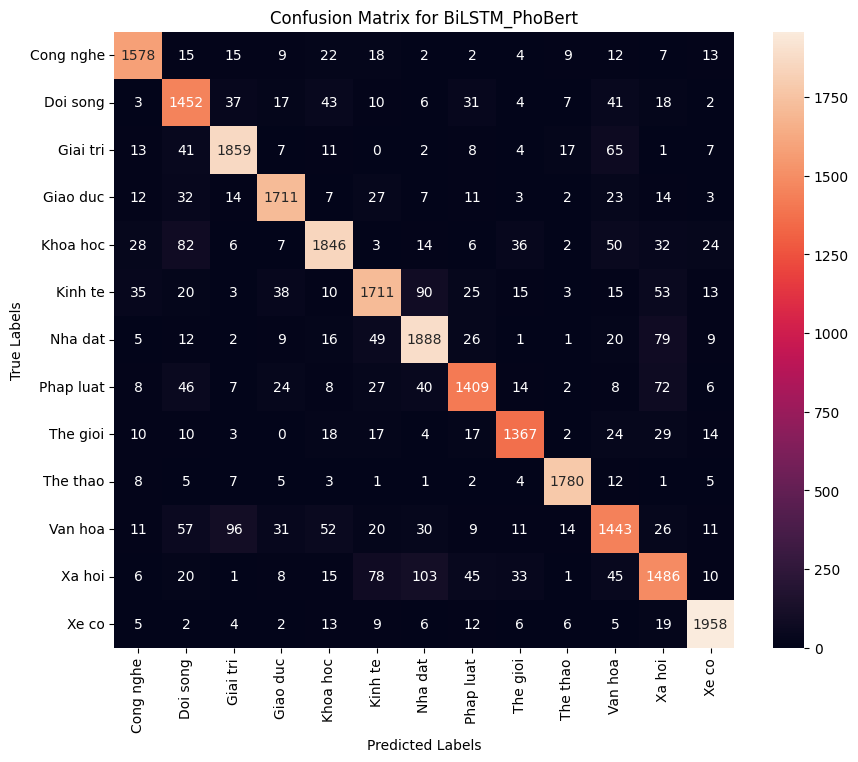

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)

# Đặt tiêu đề và nhãn cho trục
plt.title('Confusion Matrix for BiLSTM_PhoBert')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig(path + 'confusion_matrix_bilstm_phobertbase.png')

plt.show()

In [ ]:
report_df.to_csv(path + 'classification_report_bilstm_phobertbase.csv', index=True)

## Predict

In [ ]:
nlp_model = phonlp.load(save_dir=path + "phonlp")

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'[^\w\s.]', '', text)
    sentences = underthesea.sent_tokenize(text)
    preprocessed_words = []
    for sentence in sentences:
        try:
            word_tokens = underthesea.word_tokenize(sentence, format="text")
            tags = nlp_model.annotate(word_tokens, batch_size=64)
            filtered_words = [word.lower() for word, tag in zip(tags[0][0], tags[1][0]) if tag[0] not in ['M', 'X', 'CH']
                              and word not in ["'", ","]]
            preprocessed_words.extend(filtered_words)
        except Exception as e:
            pass
    return ' '.join(preprocessed_words)

# Function to create BERT features
def make_bert_features(v_text, max_len):
    v_tokenized = []
    for i_text in v_text:
        line = tokenizer.encode(i_text, truncation=True)
        v_tokenized.append(line)
    padded = []
    for i in v_tokenized:
        if len(i) < max_len:
            padded.append(i + [1] * (max_len - len(i)))
        else:
            padded.append(i[:max_len])
    padded = np.array(padded)
    attention_mask = np.where(padded == 1, 0, 1)
    padded = torch.tensor(padded).to(torch.long)
    attention_mask = torch.tensor(attention_mask)
    with torch.no_grad():
        last_hidden_states = phobert(input_ids=padded, attention_mask=attention_mask)
    v_features = last_hidden_states[0][:, 0, :].numpy()
    return v_features

def predict_label(text, tokenizer, phobert, model, class_names, max_len):
    text = preprocess_text(text)
    # Encode text using BERT tokenizer and create BERT features
    encoded_text = make_bert_features([text], max_len)
    encoded_text = np.expand_dims(encoded_text, axis=1)  # Add a new dimension

    # Predict probabilities
    prediction = model.predict(encoded_text)

    # Get predicted label
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = class_names[predicted_label_index]

    # Create confidence DataFrame
    confidences = {class_names[i]: float(prediction[0][i]) for i in range(len(prediction[0]))}
    confidence_df = pd.DataFrame(confidences, index=[0])

    return predicted_label, confidence_df

In [ ]:
text = """
Dự án Trung tâm Nghiên cứu khoa học công nghệ hạt nhân (CNST) được thực hiện theo Hiệp định Liên Chính phủ ký năm 2011. Dự án đã được Chính phủ Việt Nam phê duyệt chủ trương đầu tư năm 2018. CNST dự kiến đặt tại TP Long Khánh, Đồng Nai. Trung tâm này sẽ có lò phản ứng hạt nhân dạng bể, công suất 10 MW, sử dụng nhiên liệu độ giàu thấp do Nga chế tạo. CNST tập trung lĩnh vực vật liệu chiếu xạ, khoa học sinh học, đồng vị phóng xạ, kỹ thuật lò phản ứng, an toàn bức xạ; nghiên cứu điều chế dược chất mới trong điều trị ung thư, nghiên cứu chiếu xạ silic - vật liệu bán dẫn, tán xạ góc nhỏ...

Ông Trần Chí Thành, Viện trưởng Viện Năng lượng nguyên tử (Bộ Khoa học và Công nghệ) cho biết "đây là lần đầu tiên Việt Nam triển khai một dự án về xây dựng lò phản ứng hạt nhân nghiên cứu công suất lớn".

Theo ông Thành, để triển khai Dự án CNST, Bộ Khoa học và Công nghệ đã có những phương án chuẩn bị nguồn nhân lực quản lý và triển khai ở các giai đoạn khác nhau. Bộ cũng đưa ra kế hoạch chuẩn bị nguồn nhân lực cho vận hành đảm bảo an toàn, khai thác hiệu quả Trung tâm sau khi đi vào hoạt động.

Để hỗ trợ thẩm tra, thẩm định Báo cáo nghiên cứu khả thi, Báo cáo phân tích an toàn và hồ sơ thiết kế, Bộ Khoa học và Công nghệ đề nghị Tập đoàn Năng lượng Nguyên tử Quốc gia Liên bang Nga (Rosatom) tạo điều kiện cho một số cán bộ Việt Nam tham gia thực hiện thiết kế cơ sở của lò phản ứng và các tính toán, phân tích an toàn đi kèm. Rosatom cũng giúp Việt Nam trong đào tạo cán bộ vận hành lò phản ứng nghiên cứu.

Viện Năng lượng nguyên tử Việt Nam cũng xây dựng các nhóm chuyên môn sâu về vật lý lò, thiết kế sử dụng kênh ngang, sản xuất đồng vị phóng xạ trên lò nghiên cứu, nghiên cứu vật liệu, chiếu xạ silic làm bán dẫn, nghiên cứu phân tích kích hoạt, bảo vệ môi trường, an toàn hạt nhân. Điều này nhằm xây dựng nguồn cán bộ nghiên cứu, ứng dụng khai thác hiệu quả lò nghiên cứu mới, đảm bảo an toàn khi CNST đi vào hoạt động

Trước đó tháng 10/2017, Viện ký thỏa thuận hợp tác với Trường Đại học nghiên cứu Bách khoa Tomsk và Đại học Nghiên cứu Hạt nhân Quốc gia Nga (MEPhI) vào tháng 12/2023, về hợp tác nghiên cứu và đào tạo cán bộ trong các lĩnh vực năng lượng nguyên tử có liên quan.

Viện trưởng Trần Chí Thành cho biết thêm, trước mắt Việt Nam và Nga sẽ tập trung đẩy mạnh triển khai thực hiện Dự án đảm bảo đúng tiến độ, hiệu quả, tuân thủ các quy định của Cơ quan Năng lượng nguyên tử quốc tế (IAEA).

Theo Quy hoạch phát triển, ứng dụng năng lượng nguyên tử giai đoạn 2021 - 2030, tầm nhìn 2050, hướng nghiên cứu ứng dụng năng lượng nguyên tử sẽ tập trung cả khoa học cơ bản (vật lý hạt nhân, vật lý lò, an toàn và thủy nhiệt, tự động điều khiển, vật liệu, hóa học ...) và ứng dụng trong y tế (y học bức xạ) nông nghiệp; công nghiệp; tài nguyên môi trường (nước ngầm, ô nhiễm, phát tán phóng xạ, xói mòn đất, chất thải phóng xạ, đuôi quặng)...

Ngoài ra, trong quy hoạch phát triển ứng dụng năng lượng nguyên tử giai đoạn tới sẽ nghiên cứu tiền khả thi dự án xây dựng tổ hợp máy gia tốc lớn đặt tại miền Bắc, xây dựng các phòng thí nghiệm công nghệ và an toàn hạt nhân...
"""

predicted_label, confidences = predict_label(text, tokenizer, phobert, model, class_names, max_len)
print(f"The predicted label for the new text is: {predicted_label}")
print("Confidence scores for each label:")
confidences

100%|██████████| 1/1 [00:00<00:00, 23.32it/s]
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


1/1 [==============================] - 0s 63ms/step
The predicted label for the new text is: Khoa hoc
Confidence scores for each label:


,Cong nghe,Doi song,Giai tri,Giao duc,Khoa hoc,Kinh te,Nha dat,Phap luat,The gioi,The thao,Van hoa,Xa hoi,Xe co
0,0.000723,0.025548,0.000074,0.00598,0.956909,0.000189,0.001694,0.000049,0.00043,0.000061,0.000091,0.001248,0.007005
